In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from hyperopt import Trials, tpe, hp, fmin

import nn
import importlib
importlib.reload(nn)
from keras_utils import run_hyperopt
import conf_utils
import keras.callbacks as kcb
from keras.utils import np_utils
import keras.models as km

import pickle

from joblib import Parallel, delayed
import multiprocessing

sns.set(style='ticks', context='paper')
% config InlineBackend.figure_format = 'svg'

sigmas = np.fliplr(np.exp(pd.read_csv('logsigmas.csv', header=None).values).T)

v3_data = pd.read_csv('v3_data.csv')
cols_to_correct = ['subject', 'resp', 'contrast_id', 'g']

for col in cols_to_correct:
    v3_data[col] = v3_data[col] - 1
    
loo = pd.read_csv('loopsis.csv', header=None).values.T
xent_bayes = -loo[:,2]/2160
xent_quad = -loo[:,6]/2160

Using TensorFlow backend.


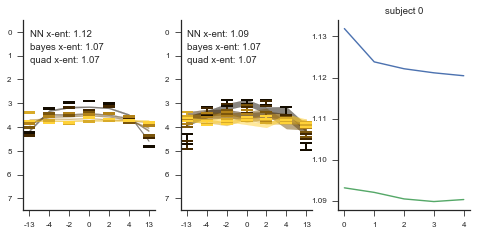

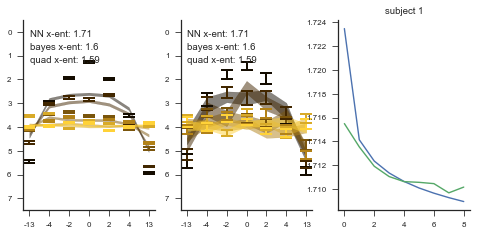

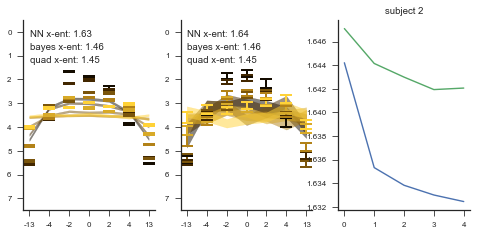

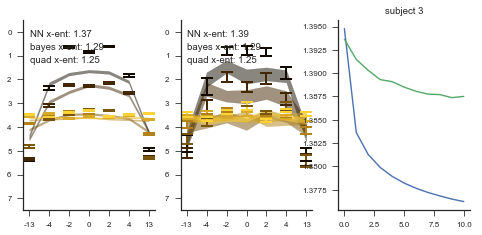

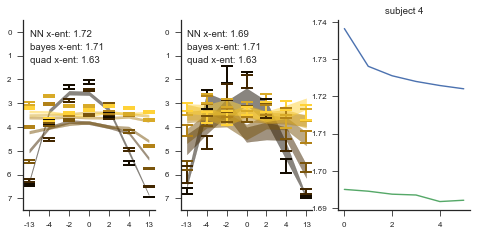

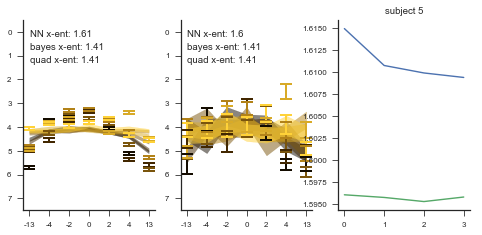

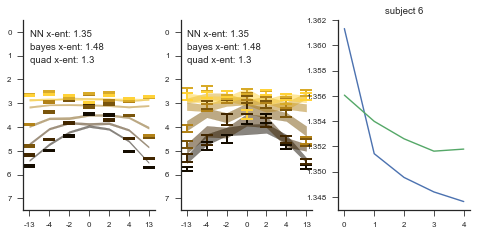

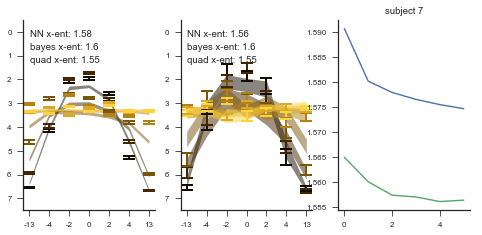

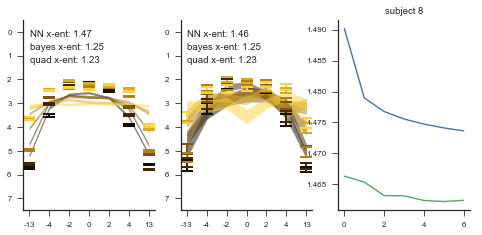

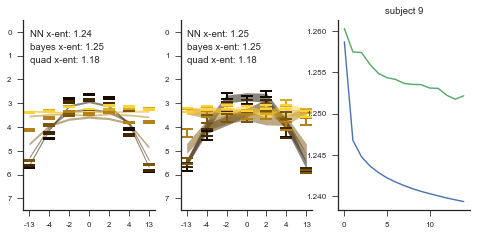

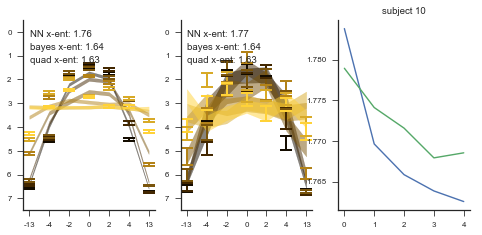

In [28]:
# TRAIN!
importlib.reload(nn)

n_epochs = 15
n_input_neurons = 50
n_train_trials = int(1e6)
c = np.arange(6)

num_cores = 8
    
n_bins = 7

p = {'nhu1': 200,
     'nhu2': 0,
     'optimizer': 'adagrad',
     'l2': 0,
     'n_train': n_train_trials,
     'batch_size': 100,
     'dropout': 0,
     'n_epochs': int(n_epochs)}


def fit_and_plot(subject):
#     n_logged_batches = 1
#     historycallback = nn.NBatchLogger(batch_interval=int(np.max([1, n_train_trials/p['batch_size']/n_logged_batches])))
    stop = kcb.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    df = nn.subject_data(v3_data, subject)
    #     df = df[df['contrast_id'].isin(c)]

    
    x_train, y_train, x_test, y_test, df_train, df_test = nn.data(df, sigmas[subject],
                                                              n_train_trials=n_train_trials,
                                                              baseline=0,
                                                              n_input_neurons=n_input_neurons,
                                                              spref_max=20)

    model, history = nn.fit_nn(p, x_train, y_train, x_test, y_test, callbacks=[stop])
    
    fig, ax = plt.subplots(1,3,figsize=(8,3.5))
    
    score_dict = {'bayes': xent_bayes[subject], 'quad': xent_quad[subject]}
    
    nn.plot_comparison(df_train, x_train, model, ax[0], comparison_score=score_dict, n_bins=n_bins,
                   plot_reliabilities=c)
    
    nn.plot_comparison(df_test, x_test, model, ax[1], comparison_score=score_dict, n_bins=n_bins,
                   plot_reliabilities=c)

    ax[2].plot(history.epoch, history.history['loss'], label='training loss')
    ax[2].plot(history.epoch, history.history['val_loss'], label='validation loss')
    ax[2].set_title('subject {}'.format(subject))
    
    plt.show()

    return model, history
    
model = [None]*11
history = [None]*11
for subject in range(11):
    model[subject], history[subject] = fit_and_plot(subject)
    model[subject].save('fitted_nets/subject{}.h5'.format(subject))

In [2]:
model = [None]*11
for subject in range(11):
    model[subject] = km.load_model('fitted_nets/subject{}.h5'.format(subject))

In [19]:
# compare nn to other models (incomplete)
xent_nn = [1.09, 1.71, 1.64, 1.39, 1.69, 1.6, 1.35, 1.56, 1.46, 1.25, 1.77]
loo_nn = -np.array(xent_nn)*2160

delta = loo-loo_nn[:,np.newaxis]

In [4]:
# generate and plot fits
importlib.reload(nn)

c = range(6)
n_input_neurons = 50

n_plot_samples = 20
n_fake_group_datasets = 1000

n_subjects = 11

n_bins = 11
edges, centers = conf_utils.quantile_bins(bins=n_bins)

n_datasets = n_subjects * n_plot_samples

class Vividict(dict):
    def __missing__(self, key):
        value = self[key] = type(self)() # retain local pointer to value
        return value                     # faster to return than dict lookup

spikes = [None]*n_datasets
resp_pred = [None]*n_datasets

trials = [None]*n_datasets

subj_mean_c_s = [None]*n_subjects
subj_mean_c_C = [None]*n_subjects

i = 0

for subject in range(n_subjects):
    df = nn.subject_data(v3_data, subject)
    df = df[df['contrast_id'].isin(c)]
    df['s_bin'] = pd.cut(df['s'], np.concatenate(([-np.inf], edges, [np.inf])), labels=False)
    
    subj_mean_c_s[subject] = df.groupby(['contrast_id', 's_bin'])['resp'].apply(np.mean)
    subj_mean_c_C[subject] = df.groupby(['contrast_id', 'C'])['resp'].apply(np.mean)
#     subj_mean[subject] = c_s_bins['resp'].apply(np.mean)
        
    for dataset in range(n_plot_samples):
        # make flat list of all datasets, then select randomly
        spikes[i] = nn.data(df, sigmas[subject],
                              baseline=0,
                              n_input_neurons=n_input_neurons,
                              spref_max=20,
                              shuffle=False)[0]
        
        resp_pred[i] = np.empty(len(df))
        for j, pvals in enumerate(model[subject].predict(spikes[i])):
            resp_pred[i][j] = np.where(np.random.multinomial(1, pvals=nn._pval_correction(pvals)))[0][0]

        trials[i] = df[['s', 's_bin', 'contrast_id', 'C']]
        
        i += 1
         
grand_subj_mean_c_s = np.array([np.mean([subj_mean_c_s[i][j] for i in range(n_subjects)], axis=0) for j in c])
grand_subj_sem_c_s = np.array([np.std([subj_mean_c_s[i][j] for i in range(n_subjects)], axis=0) for j in c])/np.sqrt(n_subjects)

grand_subj_mean_c_C = np.array([np.mean([subj_mean_c_C[i][j] for i in range(n_subjects)], axis=0) for j in c])
grand_subj_sem_c_C = np.array([np.std([subj_mean_c_C[i][j] for i in range(n_subjects)], axis=0) for j in c])/np.sqrt(n_subjects)

In [5]:
n_fake_group_datasets = 1000
synthetic_sets = [None] * n_fake_group_datasets
synthetic_set_mean_c_s = [None] * n_fake_group_datasets
synthetic_set_mean_c_C = [None] * n_fake_group_datasets


for i in range(n_fake_group_datasets):
    set = np.random.choice(220,11)
    
    synthetic_sets[i] = pd.concat([trials[i] for i in set])
    synthetic_sets[i]['resp_pred'] = np.concatenate([resp_pred[i] for i in set]).astype(int)
    
    synthetic_set_mean_c_s[i] = synthetic_sets[i].groupby(['contrast_id', 's_bin'])['resp_pred'].apply(np.mean)
    synthetic_set_mean_c_C[i] = synthetic_sets[i].groupby(['contrast_id', 'C'])['resp_pred'].apply(np.mean)

grand_nn_mean_c_s = np.array([np.mean([synthetic_set_mean_c_s[i][j] for i in range(n_fake_group_datasets)], axis=0) for j in c])
grand_nn_std_c_s = np.array([np.std([synthetic_set_mean_c_s[i][j] for i in range(n_fake_group_datasets)], axis=0) for j in c])

grand_nn_mean_c_C = np.array([np.mean([synthetic_set_mean_c_C[i][j] for i in range(n_fake_group_datasets)], axis=0) for j in c])
grand_nn_std_c_C = np.array([np.std([synthetic_set_mean_c_C[i][j] for i in range(n_fake_group_datasets)], axis=0) for j in c])

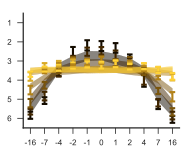

In [6]:
% config InlineBackend.figure_format = 'svg'
contrast_colors =[
    (0.0784,    0.0471,         0),
    (0.2588,    0.1529,         0),
    (0.4784,    0.3333,    0.0471),
    (0.6980,    0.5098,    0.0941),
    (0.8471,    0.6667,    0.1569),
    (1.0000,    0.8235,    0.2196)]

lw = 2.1
capsize = 2.8
fig, ax = plt.subplots(figsize=(2.8,2.11))
for i, contrast in enumerate(c):
    ax.fill_between(range(n_bins), grand_nn_mean_c_s[i] - grand_nn_std_c_s[i],
            grand_nn_mean_c_s[i] + grand_nn_std_c_s[i], color=contrast_colors[contrast], alpha=.5)
    ax.errorbar(range(n_bins), grand_subj_mean_c_s[i], grand_subj_sem_c_s[i],
                ecolor=contrast_colors[contrast],
                capsize=capsize, capthick=lw, elinewidth=lw,
                fmt='none')


# ax.invert_yaxis()

ax.set_xticks(range(n_bins))
ax.set_xticklabels(np.round(centers).astype(int))
ax.set_yticks(range(8))
ax.set_ylim((6.5,0.5))
sns.despine()

# fig.savefig('c_s.pdf')

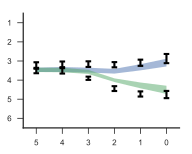

In [7]:
fig, ax = plt.subplots(figsize=(2.8,2.11))
for i in range(2):
    ax.fill_between(c, grand_nn_mean_c_C[:,i] - grand_nn_std_c_C[:,i],
            grand_nn_mean_c_C[:,i] + grand_nn_std_c_C[:,i], alpha=.5)
    ax.errorbar(c, grand_subj_mean_c_C[:,i], grand_subj_sem_c_C[:,i],
                ecolor='k',
                capsize=capsize, capthick=lw, elinewidth=lw,
                fmt='none')

ax.set_xlim((5.5, -0.5))
ax.set_xticks(np.arange(6))
ax.set_ylim((6.5, 0.5))
# ax.set_yticks(c)
sns.despine()

# fig.savefig('c_C.pdf')

In [8]:
print(np.sum(xent_nn*2160)) # sum of x-ent NN
print(np.sum(xent_quad*2160)) # LOO_Quad
print(np.sum(xent_bayes*2160)) # LOO_Bayes

35661.6
33040.7
34042.3
